### Plot grit scores for Spheroid Aggregated data

In [1]:
import pandas as pd
import numpy as np
import os

# Grit scores
from cytominer_eval import evaluate

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("white")


# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D/spher_colo52_v1/3_Figure3/GritScores
/share/data/analyses/christa/colopaint3D/spher_colo52_v1


In [2]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [3]:
# Save the data
ImagesOut = '3_Figure3/GritScores/result-images/'

if not os.path.exists(ImagesOut): 
        os.makedirs(ImagesOut)

In [4]:
cell_line = 'HT29'
data_type = 'aggregates'

In [5]:
# # Load the data
dir = '1_Data/results/'
data =  pd.read_parquet(('{}selected_data_{}_{}.parquet').format(dir, data_type, cell_line))

In [6]:
# Some function definitions

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata

### Grit

In [7]:
## Prepare the metadata for the grit calculation
dataset_grit = data.copy()

dataset_grit['Metadata_name'] = dataset_grit['Metadata_cmpdname'].str[:5] 

# Add a column with the step of the concentration (easier for plotting)
dataset_grit['Metadata_conc_step'] = (
    dataset_grit.groupby('Metadata_cmpdname')['Metadata_cmpd_conc'].rank(ascending=True, method='dense')
    )
# Add a column with the name of the perturbation (compound + concentration)
dataset_grit["Metadata_pert_name"] = (
    dataset_grit["Metadata_name"] + "_" + dataset_grit["Metadata_cmpd_conc"].astype(str)
    )
# Add a column with the a unique identifier for each replicate
dataset_grit["Metadata_replicate_id"] = (
    dataset_grit["Metadata_name"] + "_" + dataset_grit.index.astype(str)
    )

In [8]:
# Setup the data for calculating grit

# Set up the input for evaluate
control_perts = dataset_grit.query("Metadata_name == 'dmso' & Metadata_cmpd_conc == 0.1").Metadata_replicate_id.unique().tolist()
grit_replicate_groups = {"profile_col": "Metadata_replicate_id", "replicate_group_col": "Metadata_pert_name"} 

In [9]:
# Calcuate the grit scores

grit_scores = []

grit_results = evaluate(
    profiles=dataset_grit,
    features=list_features(dataset_grit)[0],
    meta_features=list_features(dataset_grit)[1],
    replicate_groups=grit_replicate_groups,
    operation="grit",
    similarity_metric="pearson",
    grit_replicate_summary_method="median",
    grit_control_perts=control_perts,
)

grit_scores.append(grit_results)

In [10]:
# Organize the grit scores

grit_scores = pd.concat(grit_scores).reset_index(drop=True)
grit_scores["Metadata_name"] = grit_scores["perturbation"].str.split("_").str[0]

# Add back the well information
grit_scores = pd.merge(grit_scores,dataset_grit[['Metadata_PlateWell', 'Metadata_replicate_id','Metadata_cmpd_conc', 'Metadata_conc_step', 'Metadata_pert_type']], left_on='perturbation', right_on='Metadata_replicate_id')

# list the compounds
CompoundsUsed = grit_scores["Metadata_name"].unique()

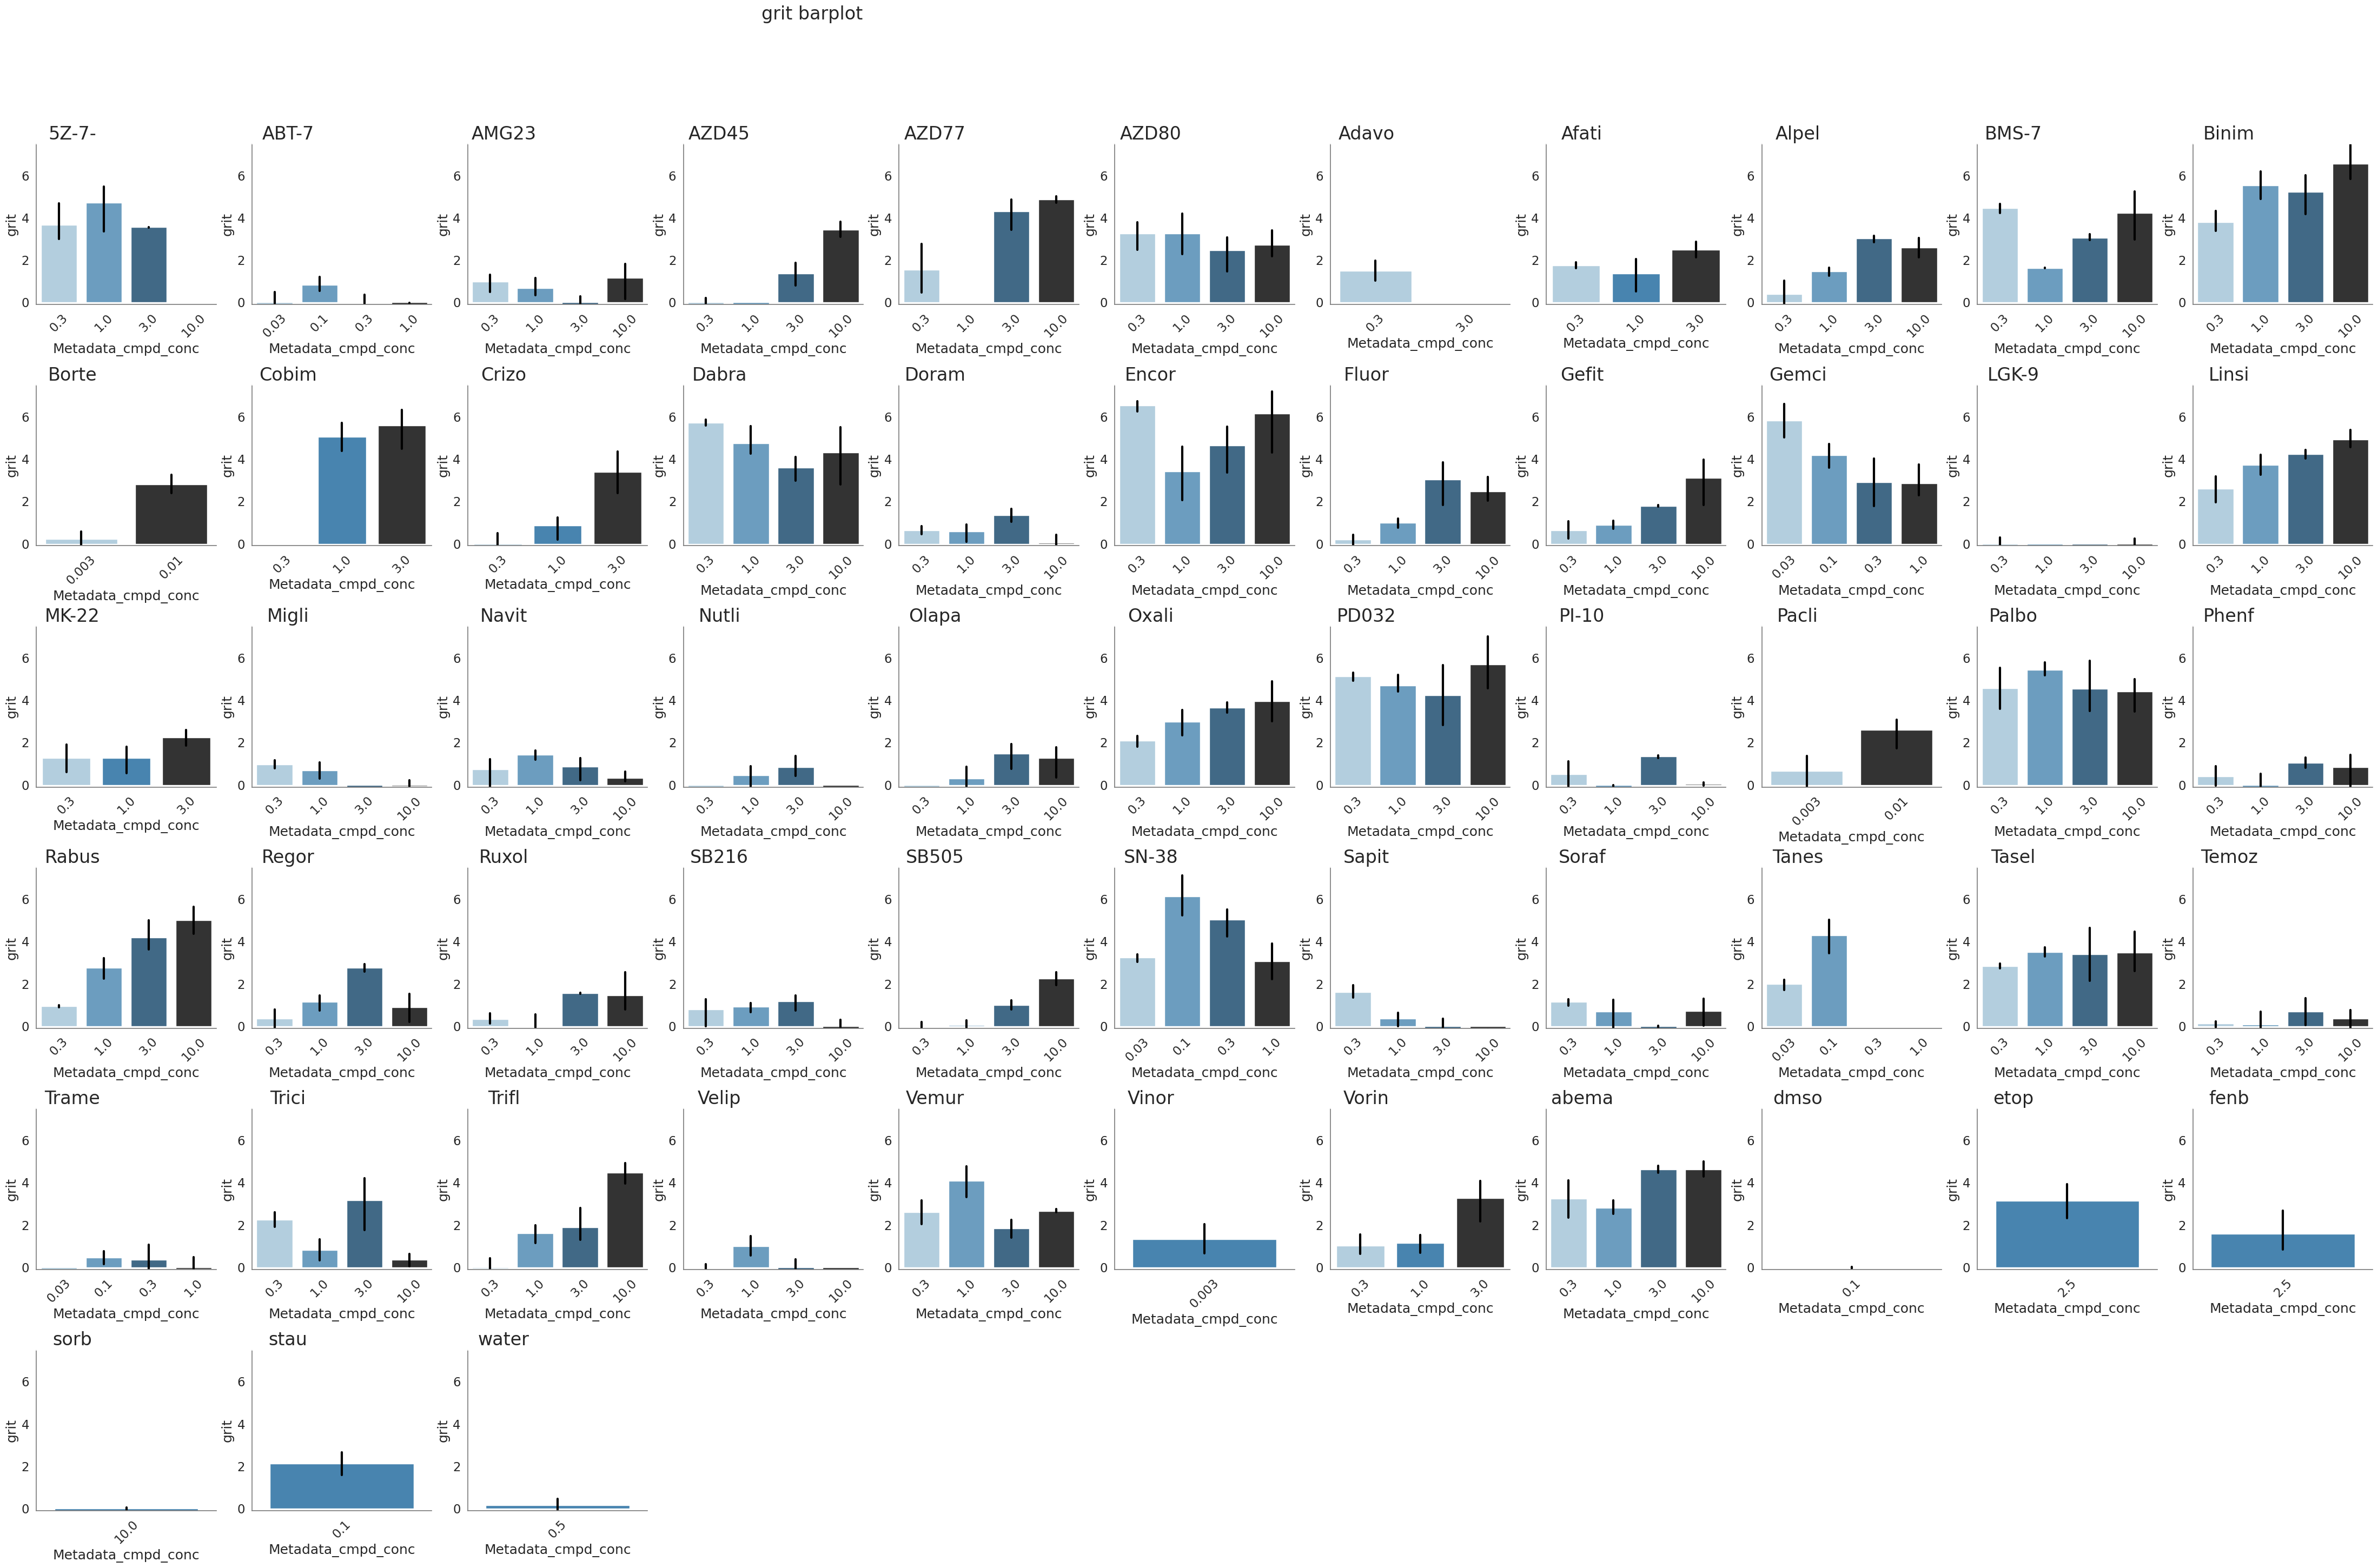

In [11]:
## Plot the grit dose response

# Plot the grit scores
fig = plt.figure(figsize=(48, 32))
sns.set(font_scale=1.5)
fig.suptitle("grit barplot ", fontsize=24, x=0.3)
sp = 1
nrrow = 6
nrcol = 11
for some in CompoundsUsed[:]:
    grit_scores_part = grit_scores[grit_scores["Metadata_name"] == some].copy()
    grit_scores_part.sort_values(by="Metadata_conc_step", inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax = sns.barplot(
        x="Metadata_cmpd_conc",
        y="grit",
        data=grit_scores_part,
        hue="Metadata_conc_step",
        legend=False,
        palette="Blues_d",
        alpha=1,
        err_kws={'linewidth': 3,'color': 'black'},
    )
    ax.set_facecolor("w")
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.set_ylim([-0.1, 7.5])
    ax.set_title("{}".format(some), fontsize=24, x=0.2)
    plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.5, left=0.0)
    plt.xticks(rotation = 45)
    sp += 1
    
fig.savefig(
        "3_Figure3/GritScores/result-images/GritScores_{}_{}.{}".format(cell_line, data_type,'png'), dpi=dpi, bbox_inches="tight"
        )

plt.show()


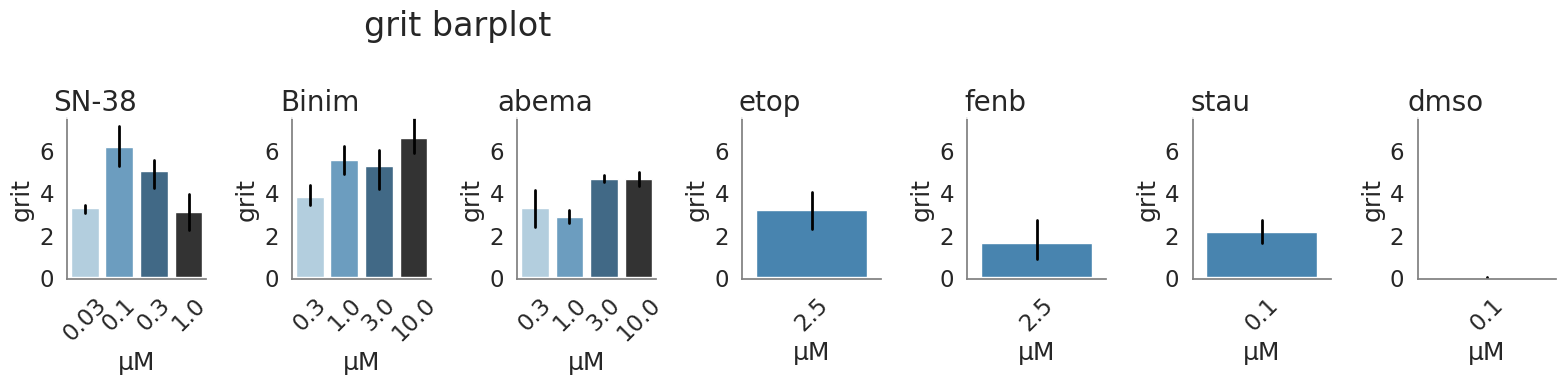

In [12]:
# Plot only a handful of compounds for the main figure

CompoundsUsed = ['SN-38', 'Binim', 'abema', 'etop','fenb','stau','dmso']


# Plot the grit scores
fig = plt.figure(figsize=(16, 4))
# sns.set(font_scale=1.5)
fig.suptitle("grit barplot ", fontsize=24, x=0.3)
sp = 1
nrrow = 1
nrcol = 7
for some in CompoundsUsed[:]:
    grit_scores_part = grit_scores[grit_scores["Metadata_name"] == some].copy()
    grit_scores_part.sort_values(by="Metadata_conc_step", inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax = sns.barplot(
        x="Metadata_cmpd_conc",
        y="grit",
        data=grit_scores_part,
        hue="Metadata_conc_step",
        legend=False,
        palette="Blues_d",
        alpha=1,
        err_kws={'linewidth': 2,'color': 'black'},
    )
    ax.set_facecolor("w")
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.set_yticks([0, 2, 4, 6])
    ax.set_ylim([-0.1, 7.5])
    ax.set_xlabel('µM')
    ax.set_title("{}".format(some), fontsize=20, x=0.2)
    plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.5, left=0.0)
    plt.xticks(rotation = 45)
    sp += 1

    fig.tight_layout()
    
fig.savefig(
        "{}GritScores_{}_{}.{}".format(ImagesOut, cell_line, data_type, figformat), dpi=dpi, bbox_inches="tight"
        )

plt.show()

#### Add gritscores to the dataset for further processing

In [13]:
# Add the grit scores to selected_df
dataset_out = dataset_grit.merge(grit_scores[['Metadata_PlateWell', 'Metadata_replicate_id', 'grit']], left_on='Metadata_PlateWell', right_on = 'Metadata_PlateWell')

# Rename the grit column to Metadata_grit
dataset_out = dataset_out.rename(columns={'grit':'Metadata_grit'})

# Save the data
OutputDir = '1_Data/results/'

# Save as parquet
dataset_out.to_parquet(('{}grit_data_{}_{}.parquet').format(OutputDir, data_type, cell_line))

#### Run a few stats and make a figure with those stats

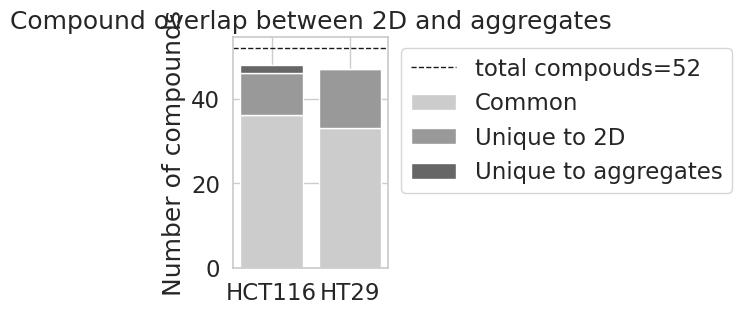

In [20]:

import ast

# --- Load all descriptive stats ---
cell_lines = ['HCT116', 'HT29']
data_types = ['2D', 'aggregates']
all_scores = []

for cell_line in cell_lines:
    for data_type in data_types:
        path = f"{ImagesOut}grit_scores_descriptive_stats_{data_type}_{cell_line}.csv"
        df = pd.read_csv(path, index_col=0)
        df['cell_line'] = cell_line
        df['data_type'] = data_type
        all_scores.append(df)

grit_scores = pd.concat(all_scores)
grit_scores = grit_scores.reset_index()  # make 'index' a column with descriptor names
grit_scores_df = grit_scores.pivot(index=['data_type', 'cell_line'], columns='index', values='grit')

# --- Convert cmpds from string to list ---
grit_scores_df['cmpds'] = grit_scores_df['cmpds'].apply(ast.literal_eval)

# --- Compare compound sets ---
stats = {}

for cell_line in cell_lines:
    df = grit_scores_df.xs(cell_line, level='cell_line')
    cmpds_2d = set(df.loc['2D', 'cmpds'])
    cmpds_agg = set(df.loc['aggregates', 'cmpds'])

    stats[cell_line] = {
        'common': cmpds_2d & cmpds_agg,
        'unique_2D': cmpds_2d - cmpds_agg,
        'unique_agg': cmpds_agg - cmpds_2d
    }

# --- Prepare data for plotting ---
x_labels = cell_lines
y_common = [len(stats[c]['common']) for c in cell_lines]
y_unique_2d = [len(stats[c]['unique_2D']) for c in cell_lines]
y_unique_agg = [len(stats[c]['unique_agg']) for c in cell_lines]

# --- Plot ---
fig = plt.figure(figsize=(2, 3))
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Use gray colormap
colors = sns.color_palette("gray", 4)[1:]  # skip lightest

plt.bar(x_labels, y_common, color=colors[2])
plt.bar(x_labels, y_unique_2d, bottom=y_common, color=colors[1])
plt.bar(x_labels,
        y_unique_agg,
        bottom=np.array(y_common) + np.array(y_unique_2d),
        color=colors[0])

plt.axhline(y=52, color='k', linestyle='--', linewidth=1)
plt.ylabel("Number of compounds")
plt.title("Compound overlap between 2D and aggregates")

plt.legend(['total compouds=52', 'Common', 'Unique to 2D', 'Unique to aggregates'],
           bbox_to_anchor=(1.01, 1),
           loc='upper left')
plt.show()

fig.savefig(
        "{}GritScores_hits.{}".format(ImagesOut, figformat), dpi=dpi, bbox_inches="tight"
        )
